In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
# parameters
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
base_learning_rate = 0.0001
optim1 = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
losse1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
losse2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim2 = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10)
metric_used = ['accuracy']


initial_epochs = 30
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

In [3]:
PATH = os.path.join('.', 'dataset')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, label_mode='int',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, label_mode='int',
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1047 files belonging to 3 classes.
Found 123 files belonging to 3 classes.


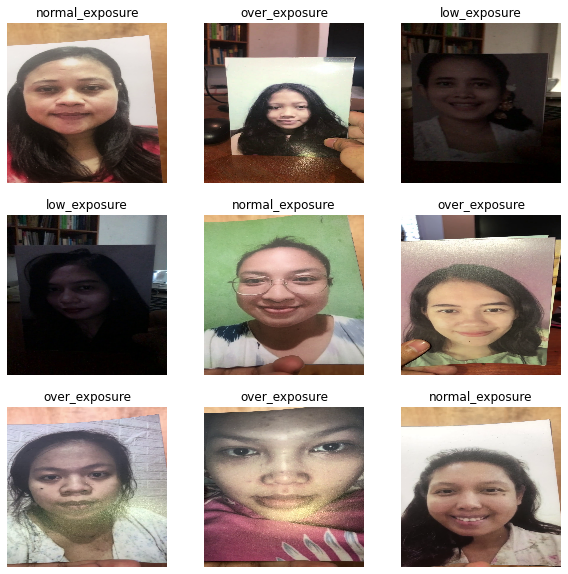

In [4]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

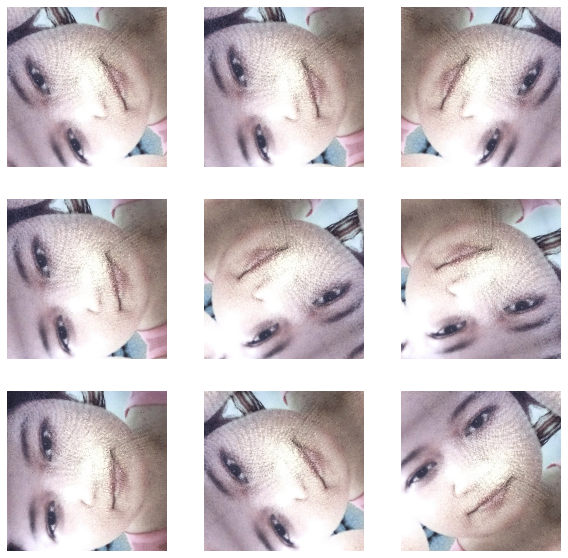

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 3)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.compile(optimizer= optim1,
              loss= losse1,
              metrics=metric_used)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [21]:
len(model.trainable_variables)

2

In [22]:


loss0, accuracy0 = model.evaluate(validation_dataset)

2/2 [==============================] - 5s 528ms/step - loss: 1.4306 - accuracy: 0.2764


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.43
initial accuracy: 0.28


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
17/17 [==============================] - 10s 345ms/step - loss: 1.3860 - accuracy: 0.2970 - val_loss: 1.4222 - val_accuracy: 0.3415
Epoch 2/30
17/17 [==============================] - 5s 160ms/step - loss: 1.1679 - accuracy: 0.3945 - val_loss: 1.3570 - val_accuracy: 0.3740
Epoch 3/30
17/17 [==============================] - 5s 158ms/step - loss: 1.0129 - accuracy: 0.4785 - val_loss: 1.2378 - val_accuracy: 0.4228
Epoch 4/30
17/17 [==============================] - 5s 159ms/step - loss: 0.9169 - accuracy: 0.5731 - val_loss: 1.1367 - val_accuracy: 0.4715
Epoch 5/30
17/17 [==============================] - 5s 171ms/step - loss: 0.8115 - accuracy: 0.6380 - val_loss: 1.0780 - val_accuracy: 0.4959
Epoch 6/30
17/17 [==============================] - 5s 173ms/step - loss: 0.7398 - accuracy: 0.6839 - val_loss: 1.0105 - val_accuracy: 0.5203
Epoch 7/30
17/17 [==============================] - 5s 175ms/step - loss: 0.6761 - accuracy: 0.7125 - val_loss: 0.9553 - val_accuracy: 0.5285
Epoch

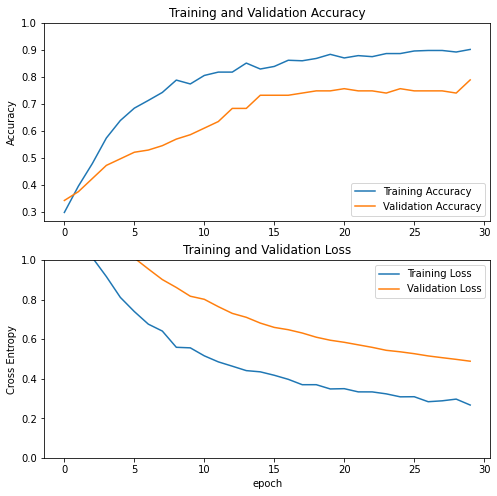

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [28]:
model.compile(loss=losse2,
              optimizer = optim2,
              metrics=metric_used)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
len(model.trainable_variables)

56

In [31]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 30/70
17/17 [==============================] - 11s 246ms/step - loss: 0.2486 - accuracy: 0.9045 - val_loss: 0.3627 - val_accuracy: 0.8699
Epoch 31/70
17/17 [==============================] - 6s 210ms/step - loss: 0.1525 - accuracy: 0.9465 - val_loss: 0.2679 - val_accuracy: 0.8862
Epoch 32/70
17/17 [==============================] - 6s 211ms/step - loss: 0.1415 - accuracy: 0.9465 - val_loss: 0.2403 - val_accuracy: 0.8943
Epoch 33/70
17/17 [==============================] - 6s 215ms/step - loss: 0.1172 - accuracy: 0.9522 - val_loss: 0.2067 - val_accuracy: 0.9268
Epoch 34/70
17/17 [==============================] - 6s 212ms/step - loss: 0.1051 - accuracy: 0.9599 - val_loss: 0.2094 - val_accuracy: 0.9268
Epoch 35/70
17/17 [==============================] - 7s 220ms/step - loss: 0.0767 - accuracy: 0.9685 - val_loss: 0.2100 - val_accuracy: 0.9268
Epoch 36/70
17/17 [==============================] - 7s 213ms/step - loss: 0.0747 - accuracy: 0.9761 - val_loss: 0.1927 - val_accuracy: 0.935

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

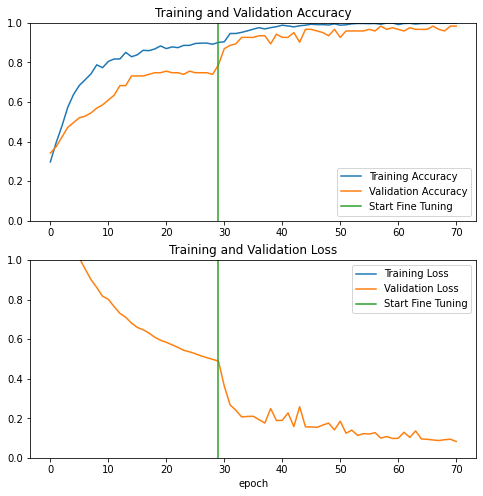

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 1s 43ms/step - loss: 0.0824 - accuracy: 0.9837
Test accuracy : 0.9837398529052734


[[20  0  0]
 [ 0 24  0]
 [ 0  1 19]]


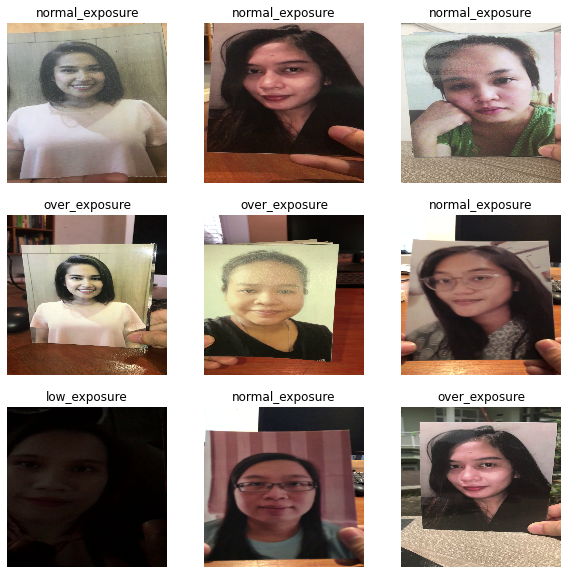

In [41]:
from sklearn.metrics import confusion_matrix

# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)

cm = confusion_matrix(label_batch, predicted_id)
print(cm)
# print(len(predicted_id))
# print(len(label_batch))
# predicted_label_batch = class_names[predicted_id]
# print(predicted_label_batch)
# print(class_names)

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.softmax(predictions)
# print(type(predictions))

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', )

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predicted_id[i]])
  plt.axis("off")